In [24]:
from PIL import Image
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})
plt.rcParams['figure.figsize'] = [4, 4]

import torch.optim as optim

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import torchvision.transforms as tvt
import torchvision

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import seaborn as sns
import copy
import gc
import cv2 as cv
import json
import time
import glob
import gzip
import pickle
import gensim
from gensim.models import KeyedVectors
import gensim.downloader as genapi

In [2]:
Path_data = '*/data'
Path_model = '*/model'

os.chdir(Path_data)
File_Names = os.listdir()

os.chdir(Path_model)
Model_names = os.listdir()

File_Names, Model_names

(['sentiment_dataset_test_200.tar.gz',
  'sentiment_dataset_test_3.tar.gz',
  'sentiment_dataset_test_40.tar.gz',
  'sentiment_dataset_test_400.tar.gz',
  'sentiment_dataset_train_200.tar.gz',
  'sentiment_dataset_train_3.tar.gz',
  'sentiment_dataset_train_40.tar.gz',
  'sentiment_dataset_train_400.tar.gz'],
 ['BiGru_Data400_HiddenSize256_NumLayers2_Lr0p00005',
  'BiGru_Data400_HiddenSize256_NumLayers2_Lr0p00005_Epoch1.pt',
  'BiGru_Seq_Data400_HiddenSize256_NumLayers2_Lr0p00005',
  'BiGru_Seq_Data400_HiddenSize256_NumLayers2_Lr0p00005_Epoch1.pt',
  'BiGru_Seq_Data40_HiddenSize256_NumLayers2_Lr0p00005',
  'BiGru_Seq_Data40_HiddenSize256_NumLayers2_Lr0p00005_Epoch1.pt',
  'Copy',
  'Gru_Data400_HiddenSize256_NumLayers2_Lr0p00005',
  'Gru_Data400_HiddenSize256_NumLayers2_Lr0p00005_Epoch0.pt',
  'Gru_Data400_HiddenSize256_NumLayers2_Lr0p00005_Epoch1.pt',
  'Gru_Data400_HiddenSize256_NumLayers2_Lr0p00005_Epoch2.pt',
  'Gru_Data400_HiddenSize256_NumLayers2_Lr0p00005_Epoch3.pt'])

In [3]:
os.chdir(Path_data)
f = gzip.open('sentiment_dataset_train_3.tar.gz', 'rb')

# extracting file
dataset = f.read()
dataset_p, dataset_n, vocab = pickle.loads(dataset, encoding='latin1')
f.close()

print('A positive feedback: ', ' '.join(dataset_p['apparel'][0]))
print('A negative feedback: ', ' '.join(dataset_n['apparel'][0]))

A positive feedback:  i dont see the difference between these bodysuits and the more expensive ones fits my boy just right
A negative feedback:  i am sorry but i did not like it nor will i wear it as it is too big looks funny on me i wish i had not have gotten it


## Word to vector

In [4]:
# download the pretrained word2vec model
# word_vectors_en = genapi.load('word2vec-google-news-300') 

# save pretrained model
path_word2vec = 'F:/0Course/Deep_Learning/NLP/word2vec-google-news-300.kv'
# word_vectors_en.save(path_word2vec)

# Load pretrained model
word2vec_model = KeyedVectors.load(path_word2vec)

# test word2vect on a sentence
sentence = ['London','is', 'the', 'capital', 'Great', 'Britain']
vectors = [word2vec_model[w] for w in sentence]
vectors[0].shape

(300,)

## Sentence to vectors

In [5]:
def sentence_to_vector(sentence):
    sentence_vector = torch.zeros(len(sentence), 300, dtype = torch.float32)
    for i,word in enumerate(sentence):
        if word in word2vec_model.key_to_index: # in case word is not in dict
            sentence_vector[i] = torch.tensor(word2vec_model[word]) 
        else:
            sentence_vector[i] = sentence_vector[i-1]
    
    return sentence_vector

sentence = ['London','is', 'the', 'capital','of' ,'Great', 'Britain']
sentence_to_vector(sentence).shape

torch.Size([7, 300])

## Dataloader

In [6]:
class Dataset(torch.utils.data.Dataset):
    
    def __init__(self, FileName_data, path_folder):
        super(Dataset, self).__init__()

        os.chdir(path_folder)
        f = gzip.open(FileName_data, 'rb')

        # extracting file
        dataset = f.read()
        dataset_p, dataset_n, vocab = pickle.loads(dataset, encoding='latin1')
        dataset_keys = dataset_p.keys()
        
        self.review = []
        self.label = []
        
        for key in dataset_keys:
            for sentence in dataset_p[key]:
                self.review.append(sentence_to_vector(sentence))
                self.label.append(1.0)
            for sentence in dataset_n[key]:
                self.review.append(sentence_to_vector(sentence))
                self.label.append(0.0)
    
    def sentence_to_vector(sentence):
        sentence_vector = torch.zeros(len(sentence), 300, dtype = torch.float32)
        for i,word in enumerate(sentence):
            if word in word2vec_model.key_to_index: # in case word is not in dict
                sentence_vector[i] = torch.tensor(word2vec_model[word]) 
            else:
                sentence_vector[i] = sentence_vector[i-1]
                
        return sentence_vector
    
    def __len__(self):
        return len(self.label)
        
    def __getitem__(self, index):
        Dict = {}
        Dict['review'] = self.review[index]
        Dict['label'] = self.label[index]
        
        return self.review[index], torch.tensor(self.label[index], dtype = torch.float)

In [20]:
# Dataset_train = Dataset('sentiment_dataset_train_400.tar.gz', Path_data)
Dataset_train = Dataset('sentiment_dataset_train_400.tar.gz', Path_data)
Dataset_test = Dataset('sentiment_dataset_test_400.tar.gz', Path_data)

dataloader_train = torch.utils.data.DataLoader(Dataset_train, batch_size = 1, shuffle = True) 
data_for_test = next(iter(dataloader_train))
next(iter(dataloader_train))

[tensor([[[-0.2256, -0.0195,  0.0908,  ...,  0.0282, -0.1777, -0.0060],
          [-0.0337,  0.0840,  0.0464,  ..., -0.2949,  0.0703, -0.1138],
          [ 0.1094,  0.1406, -0.0317,  ...,  0.0077,  0.1201, -0.1797],
          ...,
          [ 0.1094,  0.1406, -0.0317,  ...,  0.0077,  0.1201, -0.1797],
          [-0.0718, -0.0277,  0.2266,  ..., -0.1006,  0.1348, -0.2236],
          [-0.0615,  0.0952,  0.1338,  ...,  0.1396,  0.0297,  0.0008]]]),
 tensor([0.])]

In [8]:
review, label = data_for_test
review.shape
review_new = review.permute(1,0,2)

review_new.shape

torch.Size([27, 1, 300])

## GRU - Sentiment analysis model based on torch.nn.GRU()

In [9]:
class GRU_net(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x , h):
        out, hid = self.gru(x, h)
        
        # last output
        out = self.relu(out[:,-1])
        out = self.fc(out)
        
        # sigmoid for binary classification
        out = self.sigmoid(out)
        
        return out, hid

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(self.num_layers, self.batch_size, self.hidden_size).zero_()
        
        return hidden

## BiGRU - Sentiment analysis model based on torch.nn.GRU(bidirectional = True)

In [10]:
class BiGRU_net(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_layers, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.batch_size = batch_size
        
        self.gru = nn.GRU(input_size, hidden_size, num_layers, bidirectional = True)
        self.relu = nn.ReLU()
        # 2* for bidirection
        self.fc = nn.Linear(2*hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x , h):
        out, hid = self.gru(x, h)
        
        # last output
        out = self.relu(out[:,-1])
        out = self.fc(out)
        
        # sigmoid for binary classification
        out = self.sigmoid(out)
        
        return out, hid

    def init_hidden(self):
        weight = next(self.parameters()).data
        # 2* for bidirection
        hidden = weight.new(2*self.num_layers, self.batch_size, self.hidden_size).zero_()
        
        return hidden

## MyGRU - Sentiment analysis model based on my own implementation of GRU

In [11]:
class MyGRU(nn.Module):
    
    def __init__(self, input_size, hidden_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.FC_z = nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
        self.sigmoid_z = nn.Sigmoid()
        
        self.FC_r = nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
        self.sigmoid_r = nn.Sigmoid()
        
        self.FC_h = nn.Linear(self.input_size + self.hidden_size, self.hidden_size)
        self.tanh = nn.Tanh()
        
    def forward(self, input, hidden):
        hidden = torch.unsqueeze(hidden[0,:,:], 0)
        z = torch.cat((input, hidden), 2)
        z = self.FC_z(z)
        z = self.sigmoid_z(z)
        
        r = torch.cat((input, hidden), 2)
        r = self.FC_r(r)
        r = self.sigmoid_r(r) 
        
        h_t = torch.cat((input, r*hidden),2)
        h_t = self.FC_h(h_t)
        h_t = self.tanh(h_t)
        
        h = (1-z)*h_t + z*hidden
        
        return h, h
    

class MyGRU_net(nn.Module):
    
    def __init__(self, input_size, hidden_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        
        self.gru = MyGRU(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x , h):
        out, hid = self.gru(x, h)
        
        # last output
        out = self.relu(out[:,-1])
        out = self.fc(out)
        
        # sigmoid for binary classification
        out = self.sigmoid(out)
        
        return out, hid

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = weight.new(1, self.batch_size, self.hidden_size).zero_()
        
        return hidden

## Model Train/Test function

In [15]:
# def run_training(net, path_traindata, batch_size, epochs):
def run_training(net,dataset, batch_size, epochs, lr):
    time_start = time.time()
    net = copy.deepcopy(net)
    net = net.to(device)
    criterion = nn.BCELoss(reduction = 'mean')
    net.train()
    
    optimizer = optim.Adam(net.parameters(), lr = lr)
    
    loss_train = []
    label_true = []
    label_pred = []
    precision_train = []
    
    for epoch in range(epochs):
        
        loss_running_train = []
        running_loss = 0.0
        train_dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True) 
        
        for i, data in enumerate(train_dataloader):
            
            review, label = data
            review = review.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            hidden = net.init_hidden()
            
            for k in range(review.shape[1]):
                output, hidden = net(torch.unsqueeze(torch.unsqueeze(review[0,k], 0), 0 ), hidden)
            
            # print(output[0])
            loss = criterion(output[0], label)
            label_true.append(label.item())
            if output[0].item() > 0.5:
                label_pred.append(1.0)
            else:
                label_pred.append(0.0)
                
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            if (i+1)%200 == 0:
                loss_train.append(running_loss/200)
                print('[epoch: %d, iter: %4d] loss: %.5f'%(epoch +1, i+1, loss_train[-1]))
            
                running_loss = 0.0
                
        precision_train.append(accuracy_score(label_true, label_pred)) 
        print('[epoch: %d] accuracy: %.5f'%(epoch +1, precision_train[-1]))        
    time_end = time.time()
    print('\n Time cost: %.2f s'%(time_end - time_start))
    gc.collect()
    
    return net, loss_train


def run_training_pretrained(net, path_model, name_model, dataset, batch_size, epochs, lr):
    time_start = time.time()
    net = copy.deepcopy(net)
    net = net.to(device)
    criterion = nn.BCELoss(reduction = 'mean')
    net.train()
    
    save_iter = 200 # save loss every save_iter
    save_epoch = 1 # save model every save_epoch
    
    loss_train = []
    label_true = []
    label_pred = []
    precision_train = []
    
    epoch_current = -1
    
    # load the model if exist, or training from init
    os.chdir(path_model)
    if name_model in os.listdir():

        checkpoint = torch.load(name_model)

        epoch_current = checkpoint['epoch']-1
        net.load_state_dict(checkpoint['net_state'])
        optimizer = optim.Adam(net.parameters(), lr = lr)
        optimizer.load_state_dict(checkpoint['optim_state'])
        loss_train = checkpoint['loss']

        print('Pre-trained model is loaded \n')
    else:
        optimizer = optim.Adam(net.parameters(), lr = lr)
        print('Pre-trained model not found. Start new training process \n')

        
    for epoch in range(epoch_current+1, epochs):
        
        loss_running_train = []
        running_loss = 0.0
        train_dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True) 
        
        for i, data in enumerate(train_dataloader):
            
            review, label = data
            review = review.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            hidden = net.init_hidden()
            
            for k in range(review.shape[1]):
                output, hidden = net(torch.unsqueeze(torch.unsqueeze(review[0,k], 0), 0 ), hidden)
            
            # print(output[0])
            loss = criterion(output[0], label)
            label_true.append(label.item())
            if output[0].item() > 0.5:
                label_pred.append(1.0)
            else:
                label_pred.append(0.0)
                
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            if (i+1)%save_iter == 0:
                loss_train.append(running_loss/save_iter)
                print('[epoch: %d, iter: %4d] loss: %.5f'%(epoch +1, i+1, loss_train[-1]))
            
                running_loss = 0.0
                
        precision_train.append(accuracy_score(label_true, label_pred)) 
        print('[epoch: %d] accuracy: %.5f'%(epoch +1, precision_train[-1]))   
        
        if epoch%save_epoch == 0:
            save_model(net, path_model, name_model+ '_Epoch' +str(epoch+1))
            checkpoint = {'epoch': epoch+1, 
                          'net_state': net.state_dict(),
                          'optim_state': optimizer.state_dict(), 
                          'loss': loss_train}
            os.chdir(Path_model)
            torch.save(checkpoint, name_model)
            print('***' + '[Epoch %d]: Model saved'%(epoch+1) + '***\n')
        
    time_end = time.time()
    print('\n Time cost: %.2f s'%(time_end - time_start))
    gc.collect()
    
    return net, loss_train

def run_training_pretrained_sequence(net, path_model, name_model, dataset, batch_size, epochs, lr):
    time_start = time.time()
    net = copy.deepcopy(net)
    net = net.to(device)
    criterion = nn.BCELoss(reduction = 'mean')
    net.train()
    
    save_iter = 200 # save loss every save_iter
    save_epoch = 1 # save model every save_epoch
    
    loss_train = []
    label_true = []
    label_pred = []
    precision_train = []
    
    epoch_current = -1
    
    # load the model if exist, or training from init
    os.chdir(path_model)
    if name_model in os.listdir():

        checkpoint = torch.load(name_model)

        epoch_current = checkpoint['epoch']-1
        net.load_state_dict(checkpoint['net_state'])
        optimizer = optim.Adam(net.parameters(), lr = lr)
        optimizer.load_state_dict(checkpoint['optim_state'])
        loss_train = checkpoint['loss']

        print('Pre-trained model is loaded \n')
    else:
        optimizer = optim.Adam(net.parameters(), lr = lr)
        print('Pre-trained model not found. Start new training process \n')

        
    for epoch in range(epoch_current+1, epochs):
        
        loss_running_train = []
        running_loss = 0.0
        train_dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True) 
        
        for i, data in enumerate(train_dataloader):
            
            review, label = data
            review = review.to(device)
            label = label.to(device)
            
            optimizer.zero_grad()
            hidden = net.init_hidden()
            
            input_vector = review.permute(1,0,2).to(device)
            
            output, hidden = net(input_vector, hidden)
            
            # for k in range(review.shape[1]):
            #     output, hidden = net(torch.unsqueeze(torch.unsqueeze(review[0,k], 0), 0 ), hidden)
            
            # print(output[0])
            loss = criterion(output[0], label)
            label_true.append(label.item())
            if output[0].item() > 0.5:
                label_pred.append(1.0)
            else:
                label_pred.append(0.0)
                
            running_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
            if (i+1)%save_iter == 0:
                loss_train.append(running_loss/save_iter)
                print('[epoch: %d, iter: %4d] loss: %.5f'%(epoch +1, i+1, loss_train[-1]))
            
                running_loss = 0.0
                
        precision_train.append(accuracy_score(label_true, label_pred)) 
        print('[epoch: %d] accuracy: %.5f'%(epoch +1, precision_train[-1]))   
        
        if epoch%save_epoch == 0:
            save_model(net, path_model, name_model+ '_Epoch' +str(epoch+1))
            checkpoint = {'epoch': epoch+1, 
                          'net_state': net.state_dict(),
                          'optim_state': optimizer.state_dict(), 
                          'loss': loss_train}
            os.chdir(Path_model)
            torch.save(checkpoint, name_model)
            print('***' + '[Epoch %d]: Model saved'%(epoch+1) + '***\n')
        
    time_end = time.time()
    print('\n Time cost: %.2f s'%(time_end - time_start))
    gc.collect()
    
    return net, loss_train


def run_test(net, dataset, batch_size, net_init):
    time_start = time.time()
    net = copy.deepcopy(net)
    net = net.to(device)
    net.eval()
    
    label_true = []
    label_pred = []

    loss_running_train = []
    running_loss = 0.0
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True) 

    for i, data in enumerate(train_dataloader):

        review, label = data

        hidden = net_init.init_hidden()

        for k in range(review.shape[1]):
            output, hidden = net(torch.unsqueeze(torch.unsqueeze(review[0,k], 0), 0 ), hidden)

        label_true.append(label.item())
        if output[0].item() > 0.5:
            label_pred.append(1.0)
        else:
            label_pred.append(0.0)

        if (i+1)%200 == 0:
            print('[test, iter: %4d]'%(i+1))
   
    time_end = time.time()
    print('\n Time cost: %.2f s'%(time_end - time_start))
    gc.collect()
    return label_true, label_pred


def run_test_sequence(net, dataset, batch_size, net_init):
    time_start = time.time()
    net = copy.deepcopy(net)
    net = net.to(device)
    net.eval()
    
    label_true = []
    label_pred = []

    loss_running_train = []
    running_loss = 0.0
    train_dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True) 

    for i, data in enumerate(train_dataloader):

        review, label = data

        hidden = net_init.init_hidden()
        
        input_vector = review.permute(1,0,2).to(device)
            
        output, hidden = net(input_vector, hidden)
        # for k in range(review.shape[1]):
        #     output, hidden = net(torch.unsqueeze(torch.unsqueeze(review[0,k], 0), 0 ), hidden)

        label_true.append(label.item())
        if output[0].item() > 0.5:
            label_pred.append(1.0)
        else:
            label_pred.append(0.0)

        if (i+1)%200 == 0:
            print('[test, iter: %4d]'%(i+1))
   
    time_end = time.time()
    print('\n Time cost: %.2f s'%(time_end - time_start))
    gc.collect()
    return label_true, label_pred

def plot_test(label_true, label_pred):
    accu_test = accuracy_score(label_true, label_pred) 
    print('test accuracy: %.5f'%(accu_test)) 

    cf_matrix = confusion_matrix(np.array(label_true , np.uint8), np.array(label_pred , np.uint8))
    
    x_axis_labels = ['pos', 'neg'] 
    y_axis_labels = ['pos', 'neg']
    s = sns.heatmap(cf_matrix, annot=True, fmt='d', xticklabels=x_axis_labels, yticklabels=y_axis_labels)
    s.set(xlabel='Pred label', ylabel='True label')
    
def plot_loss(loss_list):
    plt.figure(figsize = (4,4))
    plt.plot(loss_list)
    plt.xlabel('iteration number (*100)')
    plt.ylabel('BCE Loss') 
    
def save_model(model, path_model, name_model):
    os.chdir(path_model)
    Model_names = os.listdir()
    save_name = name_model + '.pt'
    
    if save_name in Model_names:
        raise Exception('The model name already exist !!!!! \n Do not over write model')
        
    else:
        model.train()
        model_scripted = torch.jit.script(model) # Export to TorchScript
        model_scripted.save(save_name) # Save

def save_loss(loss_list, path_model, name_model):
    Dict = {}
    Dict['loss'] = loss_list
    save_name = name_model + '.txt'
    
    os.chdir(path_model)
    Model_names = os.listdir()
    
    if save_name in Model_names:
        raise Exception('The model name already exist !!!!! \n Do not over write model')
    else:
        f = open(save_name, 'w')
        f.write(json.dumps(Dict))
        f.close()

def load_loss(path_model, name_model):
    load_name = name_model + '.txt'
    os.chdir(path_model)
    Model_names = os.listdir()
    
    if load_name not in Model_names:
        raise Exception('The model name does not exist !!!!!')
    else:
        f = open(load_name, 'r')
        Dict = json.load(f)
        f.close()

    return Dict['loss']
        
def load_model(path_model, name_model):
    os.chdir(path_model)
    Model_names = os.listdir()
    load_name = name_model + '.pt'
    
    if load_name not in Model_names:
        raise Exception('The model name does not exist !!!!!')
    else:
        model = torch.jit.load(load_name)
    
    return model

# Train for MyGRU

In [25]:
name_model = 'MyGru_Data400_HiddenSize256_NumLayers1_Lr0p00005'
MyGru_net = MyGRU_net(input_size = 300, hidden_size=256, batch_size = 1)

MyGru_net, loss_MyGru = run_training_pretrained(MyGru_net,Path_model , name_model, Dataset_train, batch_size=1, epochs=4, lr = 5e-5)

Pre-trained model not found. Start new training process 

[epoch: 1, iter:  200] loss: 0.69314
[epoch: 1, iter:  400] loss: 0.69407
[epoch: 1, iter:  600] loss: 0.69377
[epoch: 1, iter:  800] loss: 0.68654
[epoch: 1, iter: 1000] loss: 0.69028
[epoch: 1, iter: 1200] loss: 0.69175
[epoch: 1, iter: 1400] loss: 0.68461
[epoch: 1, iter: 1600] loss: 0.67841
[epoch: 1, iter: 1800] loss: 0.68501
[epoch: 1, iter: 2000] loss: 0.64400
[epoch: 1, iter: 2200] loss: 0.72175
[epoch: 1, iter: 2400] loss: 0.67071
[epoch: 1, iter: 2600] loss: 0.64649
[epoch: 1, iter: 2800] loss: 0.66208
[epoch: 1, iter: 3000] loss: 0.66505
[epoch: 1, iter: 3200] loss: 0.59168
[epoch: 1, iter: 3400] loss: 0.59790
[epoch: 1, iter: 3600] loss: 0.59862
[epoch: 1, iter: 3800] loss: 0.60997
[epoch: 1, iter: 4000] loss: 0.57707
[epoch: 1, iter: 4200] loss: 0.62571
[epoch: 1, iter: 4400] loss: 0.66011
[epoch: 1, iter: 4600] loss: 0.62023
[epoch: 1, iter: 4800] loss: 0.57733
[epoch: 1, iter: 5000] loss: 0.58183
[epoch: 1, iter: 

[epoch: 4, iter:  400] loss: 0.35541
[epoch: 4, iter:  600] loss: 0.48238
[epoch: 4, iter:  800] loss: 0.37600
[epoch: 4, iter: 1000] loss: 0.53887
[epoch: 4, iter: 1200] loss: 0.37646
[epoch: 4, iter: 1400] loss: 0.39637
[epoch: 4, iter: 1600] loss: 0.39928
[epoch: 4, iter: 1800] loss: 0.43230
[epoch: 4, iter: 2000] loss: 0.43333
[epoch: 4, iter: 2200] loss: 0.38099
[epoch: 4, iter: 2400] loss: 0.45653
[epoch: 4, iter: 2600] loss: 0.38456
[epoch: 4, iter: 2800] loss: 0.46042
[epoch: 4, iter: 3000] loss: 0.42231
[epoch: 4, iter: 3200] loss: 0.39339
[epoch: 4, iter: 3400] loss: 0.38948
[epoch: 4, iter: 3600] loss: 0.39152
[epoch: 4, iter: 3800] loss: 0.42247
[epoch: 4, iter: 4000] loss: 0.40715
[epoch: 4, iter: 4200] loss: 0.36642
[epoch: 4, iter: 4400] loss: 0.45812
[epoch: 4, iter: 4600] loss: 0.43113
[epoch: 4, iter: 4800] loss: 0.40541
[epoch: 4, iter: 5000] loss: 0.36001
[epoch: 4, iter: 5200] loss: 0.33833
[epoch: 4, iter: 5400] loss: 0.41375
[epoch: 4, iter: 5600] loss: 0.36835
[

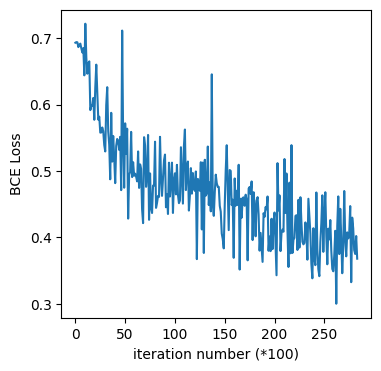

In [26]:
plot_loss(loss_MyGru)

[test, iter:  200]
[test, iter:  400]
[test, iter:  600]
[test, iter:  800]
[test, iter: 1000]
[test, iter: 1200]
[test, iter: 1400]
[test, iter: 1600]
[test, iter: 1800]
[test, iter: 2000]
[test, iter: 2200]
[test, iter: 2400]
[test, iter: 2600]
[test, iter: 2800]
[test, iter: 3000]
[test, iter: 3200]
[test, iter: 3400]

 Time cost: 171.55 s
test accuracy: 0.82571


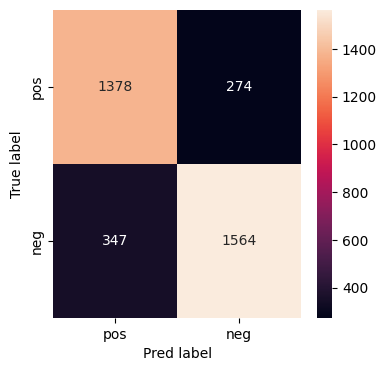

In [27]:
net_init = MyGRU_net(input_size = 300, hidden_size=256, batch_size = 1)
label_true, label_pred = run_test(MyGru_net, Dataset_test, batch_size=1, net_init = net_init)
plot_test(label_true, label_pred)

# Train for nn.GRU

In [152]:
name_model = 'Gru_Data400_HiddenSize256_NumLayers2_Lr0p00005'
Gru_net = GRU_net(input_size = 300, hidden_size=256, num_layers = 2, batch_size =1) 

Gru_net, loss_Gru = run_training_pretrained(Gru_net,Path_model , name_model, Dataset_train, batch_size=1, epochs=4, lr = 5e-5)

Pre-trained model is loaded 

[epoch: 4, iter:  200] loss: 0.54820
[epoch: 4, iter:  400] loss: 0.51902
[epoch: 4, iter:  600] loss: 0.57358
[epoch: 4, iter:  800] loss: 0.48322
[epoch: 4, iter: 1000] loss: 0.43032
[epoch: 4, iter: 1200] loss: 0.47860
[epoch: 4, iter: 1400] loss: 0.51511
[epoch: 4, iter: 1600] loss: 0.46628
[epoch: 4, iter: 1800] loss: 0.47475
[epoch: 4, iter: 2000] loss: 0.46495
[epoch: 4, iter: 2200] loss: 0.53348
[epoch: 4, iter: 2400] loss: 0.47489
[epoch: 4, iter: 2600] loss: 0.48218
[epoch: 4, iter: 2800] loss: 0.49977
[epoch: 4, iter: 3000] loss: 0.40131
[epoch: 4, iter: 3200] loss: 0.47553
[epoch: 4, iter: 3400] loss: 0.44345
[epoch: 4, iter: 3600] loss: 0.44155
[epoch: 4, iter: 3800] loss: 0.47172
[epoch: 4, iter: 4000] loss: 0.46511
[epoch: 4, iter: 4200] loss: 0.45075
[epoch: 4, iter: 4400] loss: 0.48969
[epoch: 4, iter: 4600] loss: 0.49218
[epoch: 4, iter: 4800] loss: 0.52681
[epoch: 4, iter: 5000] loss: 0.49453
[epoch: 4, iter: 5200] loss: 0.46348
[epoch: 

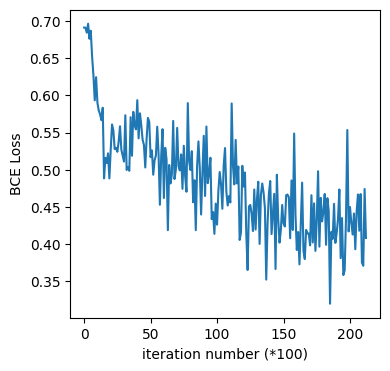

In [149]:
plot_loss(loss_Gru)

[test, iter:  200]
[test, iter:  400]
[test, iter:  600]
[test, iter:  800]
[test, iter: 1000]
[test, iter: 1200]
[test, iter: 1400]
[test, iter: 1600]
[test, iter: 1800]
[test, iter: 2000]
[test, iter: 2200]
[test, iter: 2400]
[test, iter: 2600]
[test, iter: 2800]
[test, iter: 3000]
[test, iter: 3200]
[test, iter: 3400]

 Time cost: 181.34 s
test accuracy: 0.81139


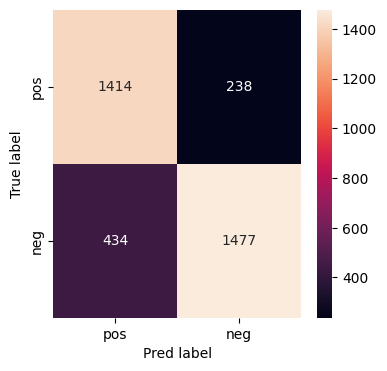

In [162]:
Gru_net = load_model(Path_model, 'Gru_Data400_HiddenSize256_NumLayers2_Lr0p00005_Epoch2')
net_init = GRU_net(input_size = 300, hidden_size=256, num_layers = 2, batch_size =1) 
label_true, label_pred = run_test(Gru_net, Dataset_test, batch_size=1, net_init = net_init)
plot_test(label_true, label_pred)

# train for nn.GRU(), bidirection

In [16]:
name_model = 'BiGru_Seq_Data400_HiddenSize256_NumLayers2_Lr0p00005'
BiGru_net = BiGRU_net(input_size = 300, hidden_size=256, num_layers = 2, batch_size =1) 

BiGru_net, loss_BiGru = run_training_pretrained_sequence(BiGru_net,Path_model , name_model, Dataset_train, batch_size=1, epochs=4, lr = 5e-5)

Pre-trained model not found. Start new training process 

[epoch: 1, iter:  200] loss: 0.69117
[epoch: 1, iter:  400] loss: 0.69357
[epoch: 1, iter:  600] loss: 0.69361
[epoch: 1, iter:  800] loss: 0.68876
[epoch: 1, iter: 1000] loss: 0.67296
[epoch: 1, iter: 1200] loss: 0.67950
[epoch: 1, iter: 1400] loss: 0.66011
[epoch: 1, iter: 1600] loss: 0.64258
[epoch: 1, iter: 1800] loss: 0.67170
[epoch: 1, iter: 2000] loss: 0.60547
[epoch: 1, iter: 2200] loss: 0.63873
[epoch: 1, iter: 2400] loss: 0.62151
[epoch: 1, iter: 2600] loss: 0.61861
[epoch: 1, iter: 2800] loss: 0.69247
[epoch: 1, iter: 3000] loss: 0.57276
[epoch: 1, iter: 3200] loss: 0.65600
[epoch: 1, iter: 3400] loss: 0.57428
[epoch: 1, iter: 3600] loss: 0.58242
[epoch: 1, iter: 3800] loss: 0.54848
[epoch: 1, iter: 4000] loss: 0.59340
[epoch: 1, iter: 4200] loss: 0.56072
[epoch: 1, iter: 4400] loss: 0.62269
[epoch: 1, iter: 4600] loss: 0.60509
[epoch: 1, iter: 4800] loss: 0.54741
[epoch: 1, iter: 5000] loss: 0.52971
[epoch: 1, iter: 

[epoch: 4, iter:  400] loss: 0.36074
[epoch: 4, iter:  600] loss: 0.31226
[epoch: 4, iter:  800] loss: 0.39178
[epoch: 4, iter: 1000] loss: 0.34535
[epoch: 4, iter: 1200] loss: 0.37249
[epoch: 4, iter: 1400] loss: 0.36124
[epoch: 4, iter: 1600] loss: 0.29094
[epoch: 4, iter: 1800] loss: 0.37512
[epoch: 4, iter: 2000] loss: 0.43023
[epoch: 4, iter: 2200] loss: 0.37067
[epoch: 4, iter: 2400] loss: 0.38413
[epoch: 4, iter: 2600] loss: 0.33400
[epoch: 4, iter: 2800] loss: 0.34184
[epoch: 4, iter: 3000] loss: 0.36340
[epoch: 4, iter: 3200] loss: 0.41328
[epoch: 4, iter: 3400] loss: 0.45566
[epoch: 4, iter: 3600] loss: 0.32150
[epoch: 4, iter: 3800] loss: 0.42737
[epoch: 4, iter: 4000] loss: 0.36928
[epoch: 4, iter: 4200] loss: 0.41473
[epoch: 4, iter: 4400] loss: 0.35540
[epoch: 4, iter: 4600] loss: 0.36191
[epoch: 4, iter: 4800] loss: 0.37042
[epoch: 4, iter: 5000] loss: 0.36163
[epoch: 4, iter: 5200] loss: 0.38613
[epoch: 4, iter: 5400] loss: 0.32852
[epoch: 4, iter: 5600] loss: 0.40110
[

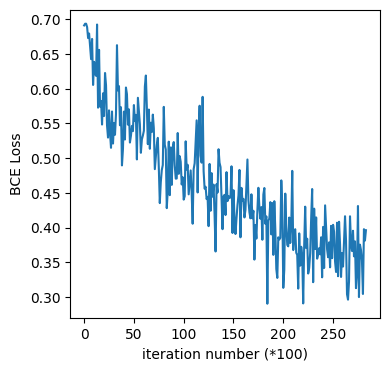

In [17]:
plot_loss(loss_BiGru)

D:\Anaconda3\lib\site-packages\torch\nn\modules\module.py:673: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\build\aten\src\ATen/core/TensorBody.h:485.)
  if param.grad is not None:


[test, iter:  200]
[test, iter:  400]
[test, iter:  600]
[test, iter:  800]
[test, iter: 1000]
[test, iter: 1200]
[test, iter: 1400]
[test, iter: 1600]
[test, iter: 1800]
[test, iter: 2000]
[test, iter: 2200]
[test, iter: 2400]
[test, iter: 2600]
[test, iter: 2800]
[test, iter: 3000]
[test, iter: 3200]
[test, iter: 3400]

 Time cost: 399.02 s
test accuracy: 0.81448


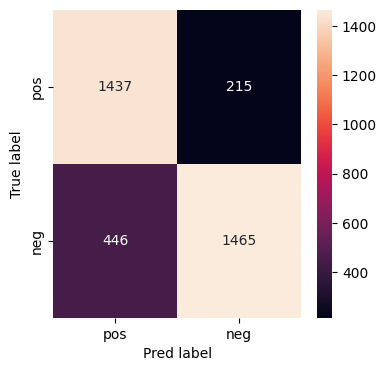

In [23]:
# BiGru_net = load_model(Path_model, 'BiGru_Seq_Data400_HiddenSize256_NumLayers2_Lr0p00005_Epoch4.pt')
net_init = BiGRU_net(input_size = 300, hidden_size=256, num_layers = 2, batch_size =1) 

label_true, label_pred = run_test(BiGru_net, Dataset_test, batch_size=1, net_init = net_init)
plot_test(label_true, label_pred)